# FASE 1 - DATA STORAGE 

## IMPORT DATASETS

In [ ]:
%pip install -r requirements.txt ;

In [78]:
import pandas as pd;
import numpy as np 
import pycountry as pc
from pyspark.sql import SparkSession

import matplotlib.pyplot as plt
import seaborn as sns


from couchbase.auth import PasswordAuthenticator
from couchbase.cluster import Cluster
from couchbase.options import ClusterOptions, QueryOptions
from couchbase.auth import PasswordAuthenticator
from couchbase.cluster import Cluster
from couchbase.options import ClusterOptions, QueryOptions
from couchbase.bucket import Bucket
from couchbase.management.buckets import CreateBucketSettings

import os
from dotenv import load_dotenv
from datetime import datetime 
from datetime import timedelta
import time
import requests

### Couchbase db setup
load_dotenv();

In [96]:
#DATASETS ESCOLHIDOS

dfLabor = pd.read_csv('datasets/world_labor_productivity.csv', delimiter=',')
#To change for the original dataset
dfSalary = pd.read_csv('datasets/world_annual_wage.csv', delimiter=',')
dfExchangeRates = pd.read_csv('datasets/exchange_rates.csv', delimiter=',')
dfMental=pd.read_csv('datasets/mental_illness.csv', delimiter=',')
dfCost = pd.read_csv('datasets/cost_of_living.csv', delimiter=',')

In [62]:
dfLabor

,Entity,Code,Year,Productivity: output per hour worked
0,Argentina,ARG,1972,5.770799
1,Argentina,ARG,1973,6.049992
2,Argentina,ARG,1974,6.123540
3,Argentina,ARG,1975,6.015602
4,Argentina,ARG,1976,6.029272
...,...,...,...,...
3452,Vietnam,VNM,2015,4.946606
3453,Vietnam,VNM,2016,5.156925
3454,Vietnam,VNM,2017,5.652919
3455,Vietnam,VNM,2018,5.982665


In [63]:
dfMental

,Entity,Code,Year,"DALYs from depressive disorders per 100,000 people in, both sexes aged age-standardized","DALYs from schizophrenia per 100,000 people in, both sexes aged age-standardized","DALYs from bipolar disorder per 100,000 people in, both sexes aged age-standardized","DALYs from eating disorders per 100,000 people in, both sexes aged age-standardized","DALYs from anxiety disorders per 100,000 people in, both sexes aged age-standardized"
0,Afghanistan,AFG,1990,895.22565,138.248250,147.64412,26.471115,440.33000
1,Afghanistan,AFG,1991,893.88434,137.761220,147.56696,25.548681,439.47202
2,Afghanistan,AFG,1992,892.34973,137.080300,147.13086,24.637949,437.60718
3,Afghanistan,AFG,1993,891.51587,136.486020,146.78812,23.863169,436.69104
4,Afghanistan,AFG,1994,891.39160,136.183230,146.58481,23.189074,436.76800
...,...,...,...,...,...,...,...,...
6835,Zimbabwe,ZWE,2015,546.46204,127.108720,115.32073,20.423056,302.20868
6836,Zimbabwe,ZWE,2016,547.27765,127.142105,114.98700,20.647228,302.68216
6837,Zimbabwe,ZWE,2017,547.62270,127.465050,115.32798,20.791725,302.88626
6838,Zimbabwe,ZWE,2018,546.57184,127.681210,115.42796,20.916480,301.58250


In [97]:
dfSalary

,COUNTRY,Country,SERIES,Series,TIME,Time,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,AUS,Australia,CPNCU,Current prices in NCU,2000,2000,AUD,Australian Dollar,0,Units,NaN,NaN,46246.868731,NaN,NaN
1,AUS,Australia,CPNCU,Current prices in NCU,2001,2001,AUD,Australian Dollar,0,Units,NaN,NaN,48315.982391,NaN,NaN
2,AUS,Australia,CPNCU,Current prices in NCU,2002,2002,AUD,Australian Dollar,0,Units,NaN,NaN,50052.758102,NaN,NaN
3,AUS,Australia,CPNCU,Current prices in NCU,2003,2003,AUD,Australian Dollar,0,Units,NaN,NaN,51798.586644,NaN,NaN
4,AUS,Australia,CPNCU,Current prices in NCU,2004,2004,AUD,Australian Dollar,0,Units,NaN,NaN,54199.402711,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2604,CRI,Costa Rica,USDPPP,In 2022 constant prices at 2022 USD PPPs,2017,2017,NaN,NaN,0,Units,NaN,NaN,27020.000000,NaN,NaN
2605,CRI,Costa Rica,USDPPP,In 2022 constant prices at 2022 USD PPPs,2018,2018,NaN,NaN,0,Units,NaN,NaN,27709.000000,NaN,NaN
2606,CRI,Costa Rica,USDPPP,In 2022 constant prices at 2022 USD PPPs,2019,2019,NaN,NaN,0,Units,NaN,NaN,28524.000000,NaN,NaN
2607,CRI,Costa Rica,USDPPP,In 2022 constant prices at 2022 USD PPPs,2020,2020,NaN,NaN,0,Units,NaN,NaN,31341.000000,NaN,NaN


In [65]:
dfCost

,Date,Country,Cost of Living,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index
0,2023,Bermuda,141.8,96.3,120.0,143.3,142.0,79.5
1,2023,Switzerland,114.2,50.2,83.5,113.9,109.5,118.7
2,2023,Cayman Islands,103.4,75.7,90.1,96.4,92.4,76.7
3,2023,Bahamas,90.9,39.6,66.3,74.1,94.8,43.2
4,2023,Barbados,88.8,21.2,56.4,80.1,82.7,36.8
...,...,...,...,...,...,...,...,...
1626,2009,Bolivia,46.7,21.8,36.8,27.1,37.2,32.5
1627,2009,China,43.5,25.1,36.2,58.4,35.2,35.0
1628,2009,Thailand,39.9,24.5,33.8,53.3,25.3,33.4
1629,2009,India,38.5,10.5,27.4,34.0,29.5,41.4


## TRATAMENTO

In [66]:
print(dfSalary.columns)

Index(['Country', 'Year', 'Unit Code', 'Salary', 'Exchange Rate'], dtype='object')


Como é possível observar, o dfSalary tem a feature 'Year' como 'Time' e a feature 'Entity' como 'Country'. De forma a uniformizar e poder fazer um merge correto, decidimos renomear as colunas.
É possível verificar que tem algumas colunas em duplicado pelo que demos drop delas

In [67]:
dfMental.rename(columns={'Entity':'Country'}, inplace=True)
dfMental.rename(columns={'DALYs from depressive disorders per 100,000 people in, both sexes aged age-standardized':'DALYs from depressive disorders per 100,000 people'}, inplace=True)
dfMental.rename(columns={'DALYs from bipolar disorder per 100,000 people in, both sexes aged age-standardized':'DALYs from bipolar disorder per 100,000 people'}, inplace=True)
dfMental.rename(columns={'DALYs from schizophrenia per 100,000 people in, both sexes aged age-standardized':'DALYs from schizophrenia per 100,000 people'}, inplace=True)
dfMental.rename(columns={'DALYs from eating disorders per 100,000 people in, both sexes aged age-standardized':'DALYs from eating disorders per 100,000 people'}, inplace=True)
dfMental.rename(columns={'DALYs from anxiety disorders per 100,000 people in, both sexes aged age-standardized':'DALYs from anxiety disorders per 100,000 people'}, inplace=True)

In [68]:
dfLabor.rename(columns={"Entity": "Country"}, inplace=True)
dfLabor.drop(columns=['Code'], inplace=True)
dfLabor.rename(columns={'Productivity: output per hour worked':'Productivity'}, inplace=True)

In [69]:
dfSalary.drop(columns=[ 'COUNTRY' , "Flag Codes", "Flags", "SERIES", "Series", "Unit", "PowerCode", "PowerCode Code","Reference Period Code", "Reference Period"], inplace=True)
dfSalary.rename(columns={'Value':'Salary'}, inplace=True)
dfSalary.rename(columns={'PowerCode':'Unit Code'}, inplace=True)
dfSalary.rename(columns={'Time':'Year'}, inplace=True)
dfSalary.drop(columns=[ 'TIME' ], inplace=True)

#Drop the countries without unit code
countriesWithoutUnitCode = dfSalary[dfSalary['Unit Code'].isna()]["Country"].unique()
dfSalary = dfSalary[~dfSalary['Country'].isin(countriesWithoutUnitCode)]
dfSalary = dfSalary.dropna(subset=['Year'])
dfSalary = dfSalary.dropna(subset=['Salary'])
dfSalary = dfSalary.dropna(subset=['Unit Code'])
dfSalary = dfSalary.dropna(subset=['Country'])

In [70]:
dfCost.rename(columns={'Date':'Year'}, inplace=True)
dfCost.rename(columns={'Cost of Living':'CoL'}, inplace=True)

In [71]:
#Lets list all the collumn names
print("Labor dataset collumns:  "+str(dfLabor.columns))
print("Salary dataset collumns: "+str(dfSalary.columns))
print("Mental Illness dataset collumns: "+str(dfMental.columns))
print("Cost of Living dataset collumns: "+str(dfCost.columns))

Labor dataset collumns:  Index(['Country', 'Year', 'Productivity'], dtype='object')
Salary dataset collumns: Index(['Country', 'Year', 'Unit Code', 'Salary', 'Exchange Rate'], dtype='object')
Mental Illness dataset collumns: Index(['Country', 'Code', 'Year',
       'DALYs from depressive disorders per 100,000 people',
       'DALYs from schizophrenia per 100,000 people',
       'DALYs from bipolar disorder per 100,000 people',
       'DALYs from eating disorders per 100,000 people',
       'DALYs from anxiety disorders per 100,000 people'],
      dtype='object')
Cost of Living dataset collumns: Index(['Year', 'Country', 'CoL', 'Rent Index',
       'Cost of Living Plus Rent Index', 'Groceries Index',
       'Restaurant Price Index', 'Local Purchasing Power Index'],
      dtype='object')


In [72]:
#Lets check the dates of the datasets
print("Labor dataset dates:  "+str(sorted(dfLabor['Year'].unique())))
print("Salary dataset dates: "+str(sorted(dfSalary['Year'].unique())))
print("Mental Illness dataset dates: "+str(sorted(dfMental['Year'].unique())))
print("Cost of Living dataset dates: "+str(sorted(dfCost['Year'].unique())))


Labor dataset dates:  [1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
Salary dataset dates: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
Mental Illness dataset dates: [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
Cost of Living dataset dates: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


In [73]:
def getExchangeRates(self):
    API_KEY = os.getenv("EXAAPI_KEY")

    # Lets use the Unit Code to get the exchange rates for each country
    # Lets collect all the Unit Codes for the countries per year
    unitCodesPerYear = {}
    for year in dfSalary['Year'].unique():
        unitCodesPerYear[year] = dfSalary[dfSalary['Year'] == year]['Unit Code'].unique().tolist()


    #Lets create a new dataset to store this information
    dfExchangeRates = pd.DataFrame(columns=['Year', 'Unit Code', 'Exchange Rate'])

    for year in unitCodesPerYear:
        
        unitCodes = ",".join([unit for unit in unitCodesPerYear[year] if str(unit)!="nan"])
        apiUrl = f"http://api.exchangeratesapi.io/v1/{str(year)}-12-12?access_key={API_KEY}&symbols=USD,{unitCodes}"
        response = requests.get(apiUrl)
        if response.status_code !=200:
            break
        exchangeRates = response.json()
        
        for index, row in dfSalary[dfSalary['Year'] == year].iterrows():
            unitCode = row['Unit Code']
            if unitCode in exchangeRates['rates']:
                exchangeRate = exchangeRates['rates'][unitCode]
                dfExchangeRates = pd.concat([dfExchangeRates, pd.DataFrame({'Year': [year], 'Unit Code': [unitCode], 'Exchange Rate': [exchangeRate]})], ignore_index=True)
            else:
                latest_exchange_rate = None
                for code, rate in exchangeRates['rates'].items():
                    if code in unitCodesPerYear[year]:
                        latest_exchange_rate = rate
                        break
                if latest_exchange_rate is not None:
                    dfExchangeRates = pd.concat([dfExchangeRates, pd.DataFrame({'Year': [year], 'Unit Code': [unitCode], 'Exchange Rate': [latest_exchange_rate]})], ignore_index=True)
    
    #Lets save the dataframe with the exchange rates 
    dfExchangeRates.to_csv('datasets/exchange_rates.csv', index=False)
    print("Exchanged successfully")

In [ ]:
def exchange():
    for row in dfSalary.iterrows():
        index, row = row
        entity = row['Country']
        unitCode = row['Unit Code']
        salary = row['Salary']
        year = row['Year']
        exchangeRate = dfExchangeRates[(dfExchangeRates['Year'] == year) & (dfExchangeRates['Unit Code'] == unitCode)]['Exchange Rate']
        if len(exchangeRate) > 0:
            exchangeRate = exchangeRate.iloc[0]
            salaryInUSD = salary / exchangeRate
            dfSalary.at[index, 'Salary'] = salaryInUSD
            dfSalary.at[index, 'Exchange Rate'] = float(exchangeRate)
        else:
            print(f"Exchange rate not found for {entity} in {year}")

exchange()

In [74]:
dfSalary

,Country,Year,Unit Code,Salary,Exchange Rate
0,Australia,2000,AUD,28513.655872,1.621920
1,Australia,2001,AUD,28017.142438,1.724515
2,Australia,2002,AUD,27800.292208,1.800440
3,Australia,2003,AUD,31325.628295,1.653553
4,Australia,2004,AUD,30771.302385,1.761362
...,...,...,...,...,...
2604,Costa Rica,2017,CRC,41.006993,658.912007
2605,Costa Rica,2018,CRC,40.769202,679.655193
2606,Costa Rica,2019,CRC,44.836115,636.183580
2607,Costa Rica,2020,CRC,42.792858,732.388565


In [75]:
dfCost

,Year,Country,CoL,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index
0,2023,Bermuda,141.8,96.3,120.0,143.3,142.0,79.5
1,2023,Switzerland,114.2,50.2,83.5,113.9,109.5,118.7
2,2023,Cayman Islands,103.4,75.7,90.1,96.4,92.4,76.7
3,2023,Bahamas,90.9,39.6,66.3,74.1,94.8,43.2
4,2023,Barbados,88.8,21.2,56.4,80.1,82.7,36.8
...,...,...,...,...,...,...,...,...
1626,2009,Bolivia,46.7,21.8,36.8,27.1,37.2,32.5
1627,2009,China,43.5,25.1,36.2,58.4,35.2,35.0
1628,2009,Thailand,39.9,24.5,33.8,53.3,25.3,33.4
1629,2009,India,38.5,10.5,27.4,34.0,29.5,41.4


In [76]:
print(dfSalary.columns)
print(dfLabor.columns) 
print(dfMental.columns) 
print(dfCost.columns)

Index(['Country', 'Year', 'Unit Code', 'Salary', 'Exchange Rate'], dtype='object')
Index(['Country', 'Year', 'Productivity'], dtype='object')
Index(['Country', 'Code', 'Year',
       'DALYs from depressive disorders per 100,000 people',
       'DALYs from schizophrenia per 100,000 people',
       'DALYs from bipolar disorder per 100,000 people',
       'DALYs from eating disorders per 100,000 people',
       'DALYs from anxiety disorders per 100,000 people'],
      dtype='object')
Index(['Year', 'Country', 'CoL', 'Rent Index',
       'Cost of Living Plus Rent Index', 'Groceries Index',
       'Restaurant Price Index', 'Local Purchasing Power Index'],
      dtype='object')


In [77]:
print("Labor dataset dates:  "+str(sorted(dfLabor['Year'].unique())))
print("Salary dataset dates: "+str(sorted(dfSalary['Year'].unique())))
print("Mental Illness dataset dates: "+str(sorted(dfMental['Year'].unique())))
print("Cost of Living dataset dates: "+str(sorted(dfCost['Year'].unique())))


Labor dataset dates:  [1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
Salary dataset dates: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
Mental Illness dataset dates: [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
Cost of Living dataset dates: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


## MERGE THE DATASETS USING PANDAS

In [78]:
start_time = time.time()
merged_df = pd.merge(dfCost, dfLabor, on=['Country', 'Year'], how='inner')
merged_df = pd.merge(merged_df, dfMental, on=['Country', 'Year'], how='inner')
merged_df = pd.merge(merged_df, dfSalary, on=['Country', 'Year'], how='inner')
end_time = time.time()
elapsed_time = end_time - start_time

print("Elapsed time:", elapsed_time, "seconds")

Elapsed time: 0.009246826171875 seconds


In [79]:
merged_df

,Year,Country,CoL,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,Productivity,Code,"DALYs from depressive disorders per 100,000 people","DALYs from schizophrenia per 100,000 people","DALYs from bipolar disorder per 100,000 people","DALYs from eating disorders per 100,000 people","DALYs from anxiety disorders per 100,000 people",Unit Code,Salary,Exchange Rate
0,2019,Switzerland,121.2,50.2,87.1,120.8,123.1,129.7,82.918655,CHE,635.31090,178.67760,202.48970,107.115810,650.54030,CHF,80501.214284,1.101884
1,2019,Switzerland,121.2,50.2,87.1,120.8,123.1,129.7,82.918655,CHE,635.31090,178.67760,202.48970,107.115810,650.54030,CHF,82253.667355,1.101884
2,2019,Switzerland,121.2,50.2,87.1,120.8,123.1,129.7,82.918655,CHE,635.31090,178.67760,202.48970,107.115810,650.54030,USD,63642.353379,1.118579
3,2019,Iceland,101.9,48.3,76.1,92.1,111.8,91.8,64.244220,ISL,485.75662,177.96698,195.80510,96.615060,489.77250,ISK,80314.306626,136.701286
4,2019,Iceland,101.9,48.3,76.1,92.1,111.8,91.8,64.244220,ISL,485.75662,177.96698,195.80510,96.615060,489.77250,ISK,92554.279263,136.701286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057,2009,Mexico,54.2,22.4,41.6,40.0,48.7,42.9,19.709696,MEX,610.59094,181.27681,198.06451,50.877518,352.22714,MXN,11836.286902,18.960169
1058,2009,Mexico,54.2,22.4,41.6,40.0,48.7,42.9,19.709696,MEX,610.59094,181.27681,198.06451,50.877518,352.22714,USD,12804.494850,1.468703
1059,2009,Poland,53.5,34.8,46.1,40.7,44.6,26.9,25.316256,POL,317.68677,187.14354,119.24043,35.298910,298.42096,PLN,9321.037129,4.126043
1060,2009,Poland,53.5,34.8,46.1,40.7,44.6,26.9,25.316256,POL,317.68677,187.14354,119.24043,35.298910,298.42096,PLN,13431.270590,4.126043


## MERGE THE DATASETS USING PYSPARK 

In [80]:
from pyspark.sql import SparkSession

start_time = time.time()
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Merge Datasets") \
    .getOrCreate()

merged_df = dfSalary.merge(dfCost, on=['Year', 'Country'], how='inner')
merged_df = merged_df.merge(dfMental, on=['Year', 'Country'], how='inner')
merged_df = merged_df.merge(dfLabor, on=['Year', 'Country'], how='inner')
print(merged_df)

# Stop SparkSession
spark.stop()

end_time = time.time()
elapsed_time = end_time - start_time

print("Elapsed time:", elapsed_time, "seconds")



         Country  Year Unit Code        Salary  Exchange Rate    CoL  \
0      Australia  2009       AUD  44503.211337       1.468703   83.3   
1      Australia  2010       AUD  52218.827944       1.323469  100.5   
2      Australia  2011       AUD  55752.868852       1.308973  107.8   
3      Australia  2012       AUD  60724.550903       1.237539  123.0   
4      Australia  2013       AUD  49732.696011       1.540194  133.7   
...          ...   ...       ...           ...            ...    ...   
1057  Costa Rica  2015       CRC     44.788853     584.654401   62.5   
1058  Costa Rica  2016       CRC     47.181337     579.975091   57.8   
1059  Costa Rica  2017       CRC     41.006993     658.912007   58.6   
1060  Costa Rica  2018       CRC     40.769202     679.655193   56.2   
1061  Costa Rica  2019       CRC     44.836115     636.183580   50.9   

      Rent Index  Cost of Living Plus Rent Index  Groceries Index  \
0           48.2                            69.4             98.9 

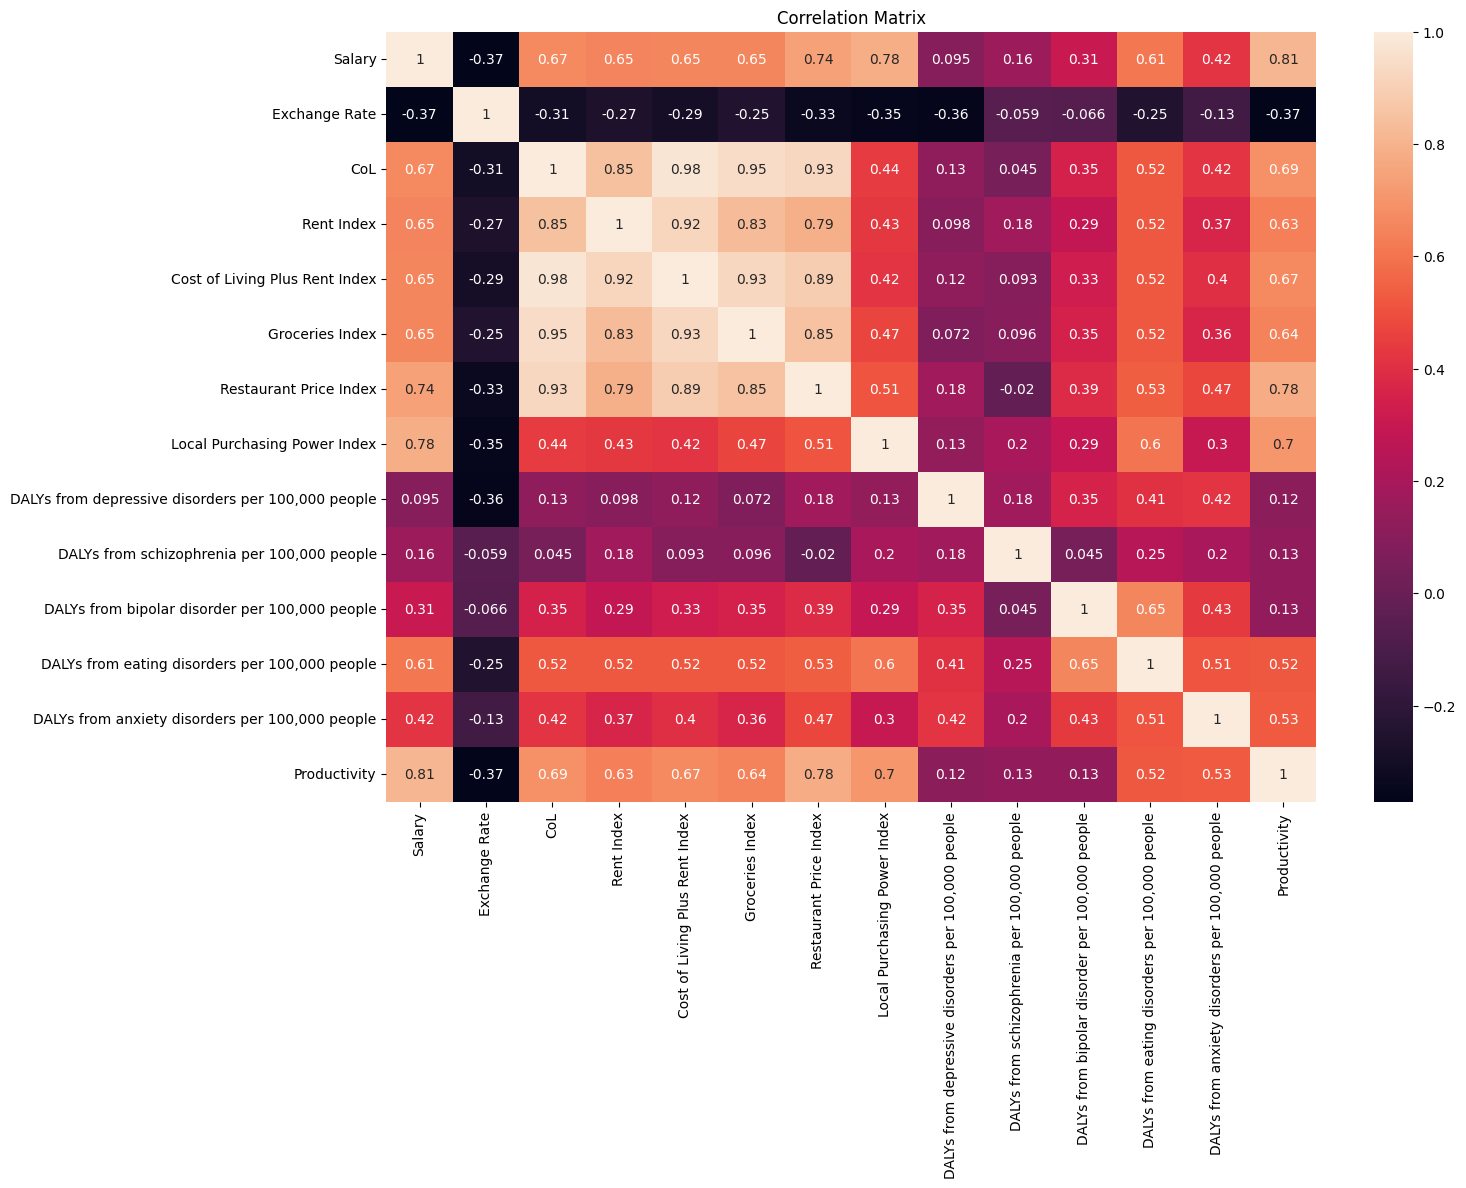

In [81]:
#Lets drop the collumns that wont add value to the analysis
correlationDF = merged_df.drop(columns=['Year', 'Country', 'Code', "Unit Code"])
#Lets apply a correlation matrix to determine if any data is correlated
correlation_matrix = correlationDF.corr()
#Plot the correlation matrix
plt.figure(figsize=(15,10))
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()

# Now we are going to the next step in the pipeline that is the storage
We will use Couchbase db and we will benchmark what would be the better option, storing the documents(each dataset) individually or merge them by running the same queries on both options

In [30]:

couchbaseUsername, couchbasePassword = os.getenv('COUCHBASE_USERNAME'), os.getenv('COUCHBASE_PASSWORD')


# get a reference to our cluster
auth = PasswordAuthenticator(couchbaseUsername, couchbasePassword)
cluster = Cluster.connect('couchbase://127.0.0.1', ClusterOptions(auth))


#Datasets structure:
#[(bucket_name, dataset)]
def db_populator(datasets, options=None):
    for i in datasets:
        bucketName, dataset = i
        if options!=None:
            bucketSettings = CreateBucketSettings(name=options["name"], 
                                                bucket_type=options["bucket_type"], 
                                                ram_quota_mb=options["ram_quota_mb"], 
                                                max_expiry=options["max_expiry"], 
                                                compression_mode=options["compression_mode"], 
                                                conflict_resolution_type=options["conflict_resolution_type"])
        else:
            bucketSettings = CreateBucketSettings(name=bucketName, 
                                                bucket_type="couchbase", 
                                                ram_quota_mb=100, 
                                                max_expiry=0, 
                                                compression_mode="passive", 
                                                conflict_resolution_type="seqno")
            
        
        print(f"Populating {bucketName} with {len(dataset)} documents")
        #Create the bucket to store the files
        try:
             
            cluster.buckets().create_bucket(bucketSettings, name=f'{bucketName}')
            print('Bucket created')
            #TODO: Rever isto, por vezes demora mais a criar o bucket
            cluster.wait_until_ready(timedelta(seconds=20))

        except Exception as e:
            if "Bucket with given name already exists" in str(e):
                pass

        #Lets create a new collection to store the data
        bucket = cluster.bucket(bucketName)
        collection = bucket.default_collection()

        #Lets store the data in the collection
        #Lets store the data in the collection
        #Lets get the last id in the bucket
        i=0
        for row in dataset.iterrows():
            data = row[1].to_dict()
            #Rever se este id é necessário visto que depois corremos o create_primary_index
            data["_id"] = f"{i}"
            collection.upsert(str(i), data)
            i+=1

        print('Data stored')
        #Lets create the index for the data
        try:
            cluster.query_indexes().create_primary_index(bucketName)
            print('Index created')
        except Exception as e:
            if "already exists" in str(e):
                pass    


def runBenchmarks():
    #Lets make some queries to the data
    agregationQuerySingleBucket = f"""
    SELECT `Country`,
        Year,
        AVG(`CoL`) AS Avg_CoL,
        MEDIAN(`CoL`) AS Median_CoL
    FROM `world_data`
    GROUP BY `Country`,
            Year
    ORDER BY RANDOM();
    """

    timeBeforeQuery = datetime.now()
    cluster.query(agregationQuerySingleBucket)
    timeAfterQuery = datetime.now()
    print(f"Time to run agregation query in the merged dataset: {(timeAfterQuery-timeBeforeQuery)*1000} ms")

    agregationQueryMultipleBucket = f"""
    SELECT `Country`,
        Year,
        AVG(`CoL`) AS Avg_CoL,
        MEDIAN(`CoL`) AS Median_CoL
    FROM `cost_of_living`
    GROUP BY `Country`,
            Year
    ORDER BY RANDOM();
    """

    timeBeforeQueryMB = datetime.now()
    cluster.query(agregationQueryMultipleBucket)
    timeAfterQueryMB= datetime.now()
    print(f"Time to run agregation query in the datasets: {(timeAfterQueryMB-timeBeforeQueryMB)*1000} ms")
    print(f"Time comparison between the merged and the not merged dataset: {((timeAfterQuery-timeBeforeQuery)-(timeAfterQueryMB-timeBeforeQueryMB))*1000} ms")
    print("---------------------------------------")

    yearQuerySingleBucket = f"""
        SELECT Year,
            AVG(`CoL`) AS Mean_Cost_of_Living
        FROM `world_data`
        GROUP BY Year
        ORDER BY RANDOM()
        """

    timeBeforeQuery = datetime.now()
    cluster.query(yearQuerySingleBucket)
    timeAfterQuery = datetime.now()
    print(f"Time to run year query in the merged dataset: {(timeAfterQuery-timeBeforeQuery)*1000} ms")


    yearQueryMultipleBucket = f"""
        SELECT Year,
            AVG(`CoL`) AS Mean_Cost_of_Living
        FROM `cost_of_living`
        GROUP BY Year
        ORDER BY RANDOM()
        """

    timeBeforeQueryMB = datetime.now()
    cluster.query(yearQueryMultipleBucket)
    timeAfterQueryMB= datetime.now()
    print(f"Time to run year query in the datasets: {(timeAfterQueryMB-timeBeforeQueryMB)*1000} ms")
    print(f"Time comparison between the merged and the not merged dataset: {((timeAfterQuery-timeBeforeQuery)-(timeAfterQueryMB-timeBeforeQueryMB))*1000} ms")
    print("---------------------------------------")


    top5QuerySingleBucket = f"""
        WITH CountryStats AS (
            SELECT `Country` AS Entity,
                AVG(`CoL`) AS Avg_CoL,
                MEDIAN(`CoL`) AS Median_CoL
            FROM `world_data`
            GROUP BY Entity )
        SELECT Entity,
            Avg_CoL,
            Median_CoL
        FROM CountryStats
        ORDER BY Avg_CoL DESC
        LIMIT 5;
        """

    timeBeforeQuery = datetime.now()
    cluster.query(top5QuerySingleBucket)
    timeAfterQuery = datetime.now()
    print(f"Time to run top5 query in the merged dataset: {(timeAfterQuery-timeBeforeQuery)*1000} ms")



    top5QueryMultipleBucket = f"""
        WITH CountryStats AS (
            SELECT `Country` AS Entity,
                AVG(`CoL`) AS Avg_CoL,
                MEDIAN(`CoL`) AS Median_CoL
            FROM `cost_of_living`
            GROUP BY Entity )
        SELECT Entity,
            Avg_CoL,
            Median_CoL
        FROM CountryStats
        ORDER BY Avg_CoL DESC
        LIMIT 5;
        """

    timeBeforeQueryMB = datetime.now()
    cluster.query(top5QueryMultipleBucket)
    timeAfterQueryMB= datetime.now()
    print(f"Time to run top5 query in the datasets: {(timeAfterQueryMB-timeBeforeQueryMB)*1000} ms")
    print(f"Time comparison between the merged and the not merged dataset: {((timeAfterQuery-timeBeforeQuery)-(timeAfterQueryMB-timeBeforeQueryMB))*1000} ms")
    print("---------------------------------------")



    mentalIllnessSingleBucket = f"""
        SELECT `Country`, SUM(`DALYs from depressive disorders per 100,000 people` +
                `DALYs from schizophrenia per 100,000 people` +
                `DALYs from bipolar disorder per 100,000 people` +
                `DALYs from eating disorders per 100,000 people` +
                `DALYs from anxiety disorders per 100,000 people`) AS Total_DALYs
        FROM `world_data`
        WHERE Year = 2009
        GROUP BY `Country`
        ORDER BY Total_DALYs DESC
        LIMIT 5;
        """    

    timeBeforeQuery = datetime.now()
    cluster.query(mentalIllnessSingleBucket)
    timeAfterQuery = datetime.now()
    print(f"Time to run top5 query in the merged dataset: {(timeAfterQuery-timeBeforeQuery)*1000} ms")


    mentalIllnessMultipleBucket = f"""
        SELECT `Country`, SUM(`DALYs from depressive disorders per 100,000 people` +
                `DALYs from schizophrenia per 100,000 people` +
                `DALYs from bipolar disorder per 100,000 people` +
                `DALYs from eating disorders per 100,000 people` +
                `DALYs from anxiety disorders per 100,000 people`) AS Total_DALYs
        FROM `mental_illness`
        WHERE Year = 2009
        GROUP BY `Country`
        ORDER BY Total_DALYs DESC
        LIMIT 5;
        """    

    timeBeforeQueryMB = datetime.now()
    cluster.query(mentalIllnessMultipleBucket)
    timeAfterQueryMB= datetime.now()
    print(f"Time to run top5 query in the datasets: {(timeAfterQueryMB-timeBeforeQueryMB)*1000} ms")
    print(f"Time comparison between the merged and the not merged dataset: {((timeAfterQuery-timeBeforeQuery)-(timeAfterQueryMB-timeBeforeQueryMB))*1000} ms")
    print("---------------------------------------")

    hardQuery = f"""
        WITH avg_dalys AS (
        SELECT `Country`,
            AVG(`DALYs from depressive disorders per 100,000 people` + 
            `DALYs from bipolar disorder per 100,000 people` + 
            `DALYs from eating disorders per 100,000 people` + 
            `DALYs from anxiety disorders per 100,000 people`) AS Avg_DALYs
        FROM `world_data`
        WHERE Year BETWEEN 2009 AND 2015
        GROUP BY `Country` )
    SELECT d.`Country`,
        d.Year,
        d.`CoL`,
        d.`Rent Index`,
        d.`Cost of Living Plus Rent Index`,
        d.`Groceries Index`,
        d.`Restaurant Price Index`,
        d.`Local Purchasing Power Index`,
        d.`Productivity`,
        d.`DALYs from depressive disorders per 100,000 people`,
        d.`DALYs from bipolar disorder per 100,000 people`,
        d.`DALYs from eating disorders per 100,000 people`,
        d.`DALYs from anxiety disorders per 100,000 people`
    FROM `world_data` d
        JOIN avg_dalys a ON d.`Country` = a.`Country`
    WHERE d.Year = 2010
        AND d.`Productivity` < (
        SELECT AVG(`Productivity`)
        FROM `world_data`
        WHERE Year = 2012 )
        AND d.`DALYs from depressive disorders per 100,000 people` < a.Avg_DALYs
    ORDER BY d.`Cost of Living Plus Rent Index` DESC,
            d.`Local Purchasing Power Index` ASC
    LIMIT 10;
    """

    timeBeforeQuery = datetime.now()
    cluster.query(hardQuery)
    timeAfterQuery = datetime.now()
    print(f"Time to run top10 hard query in the merged dataset: {(timeAfterQuery-timeBeforeQuery)*1000} ms")



    hardQueryNonMerged = """
    WITH avg_dalys AS (
        SELECT `Country`,
            AVG(`DALYs from depressive disorders per 100,000 people` + 
            `DALYs from bipolar disorder per 100,000 people` + 
            `DALYs from eating disorders per 100,000 people` + 
            `DALYs from anxiety disorders per 100,000 people`) AS Avg_DALYs
        FROM `mental_illness`
        WHERE Year BETWEEN 2009 AND 2015
        GROUP BY `Country`
    ),
    avg_productivity AS (
        SELECT `Country`,
            AVG(`Productivity`) AS Avg_Productivity
        FROM `world_labor_productivity`
        WHERE Year = 2012
        GROUP BY `Country`
    )
    SELECT d.`Country`,
        d.Year,
        d.`CoL`,
        d.`Rent Index`,
        d.`Cost of Living Plus Rent Index`,
        d.`Groceries Index`,
        d.`Restaurant Price Index`,
        d.`Local Purchasing Power Index`,
        d.`Productivity`,
        d.`DALYs from depressive disorders per 100,000 people`,
        d.`DALYs from bipolar disorder per 100,000 people`,
        d.`DALYs from eating disorders per 100,000 people`,
        d.`DALYs from anxiety disorders per 100,000 people`
    FROM `cost_of_living` d
        JOIN avg_dalys a ON d.`Country` = a.`Country`
        JOIN `world_annual_wage` s ON d.`Country` = s.`Country` AND d.Year = s.Year
        JOIN avg_productivity ap ON d.`Country` = ap.`Country`
    WHERE d.Year = 2012
        AND d.`Productivity` < ap.Avg_Productivity
        AND d.`DALYs from depressive disorders per 100,000 people` < a.Avg_DALYs
    ORDER BY d.`Cost of Living Plus Rent Index` DESC,
            d.`Local Purchasing Power Index` ASC
    LIMIT 10;

    """

    timeBeforeQueryMB = datetime.now()
    cluster.query(hardQueryNonMerged)
    timeAfterQueryMB= datetime.now()
    print(f"Time to run top10 hard query in the datasets: {(timeAfterQueryMB-timeBeforeQueryMB)*1000} ms")
    print(f"Time comparison between the merged and the not merged dataset: {((timeAfterQuery-timeBeforeQuery)-(timeAfterQueryMB-timeBeforeQueryMB))*1000} ms")
    print("---------------------------------------")


    hardQuery2Merged = f"""
    WITH avg_dalys AS (
        SELECT Country,
            AVG(`DALYs from depressive disorders per 100,000 people` + `DALYs from schizophrenia per 100,000 people` + `DALYs from bipolar disorder per 100,000 people` + `DALYs from eating disorders per 100,000 people` + `DALYs from anxiety disorders per 100,000 people`) AS Avg_DALYs
        FROM `world_data`
        GROUP BY Country ),
    avg_prod AS (
        SELECT Country,
            AVG(Productivity) AS Avg_Productivity
        FROM `world_data`
        GROUP BY Country ),
    avg_salary AS (
        SELECT Country,
            AVG(Salary) AS Avg_Salary
        FROM `world_data`
        GROUP BY Country )
    SELECT m.Country,
        ad.Avg_DALYs,
        ap.Avg_Productivity,
        asl.Avg_Salary
    FROM `world_data` m
        JOIN avg_dalys ad ON m.Country = ad.Country
        JOIN avg_prod ap ON m.Country = ap.Country
        JOIN avg_salary asl ON m.Country = asl.Country;
    """

    timeBeforeQuery = datetime.now()
    cluster.query(hardQuery2Merged)
    timeAfterQuery = datetime.now()
    print(f"Time to run hard query number 2 in the merged dataset: {(timeAfterQuery-timeBeforeQuery)*1000} ms")


    hardQuery2NonMerged = f"""
    WITH avg_dalys AS (
        SELECT Country,
            AVG(`DALYs from depressive disorders per 100,000 people` + `DALYs from schizophrenia per 100,000 people` + `DALYs from bipolar disorder per 100,000 people` + `DALYs from eating disorders per 100,000 people` + `DALYs from anxiety disorders per 100,000 people`) AS Avg_DALYs
        FROM `mental_illness`
        GROUP BY Country ),
    avg_prod AS (
        SELECT Country,
            AVG(Productivity) AS Avg_Productivity
        FROM `world_labor_productivity`
        GROUP BY Country ),
    avg_salary AS (
        SELECT Country,
            AVG(Salary) AS Avg_Salary
        FROM `world_annual_wage`
        GROUP BY Country )
    SELECT m.Country,
        ad.Avg_DALYs,
        ap.Avg_Productivity,
        asl.Avg_Salary
    FROM `cost_of_living` m
        JOIN avg_dalys ad ON m.Country = ad.Country
        JOIN avg_prod ap ON m.Country = ap.Country
        JOIN avg_salary asl ON m.Country = asl.Country;
    """

    timeBeforeQueryMB = datetime.now()
    cluster.query(hardQuery2NonMerged)
    timeAfterQueryMB= datetime.now()
    print(f"Time to run hard query number 2 in the datasets: {(timeAfterQueryMB-timeBeforeQueryMB)*1000} ms")
    print(f"Time comparison between the merged and the not merged dataset: {((timeAfterQuery-timeBeforeQuery)-(timeAfterQueryMB-timeBeforeQueryMB))*1000} ms")
    print("---------------------------------------")



    hardQuery3Merged = f"""
    WITH avg_dalys AS (
        SELECT Country,
            AVG(`DALYs from depressive disorders per 100,000 people` + `DALYs from schizophrenia per 100,000 people` + `DALYs from bipolar disorder per 100,000 people` + `DALYs from eating disorders per 100,000 people` + `DALYs from anxiety disorders per 100,000 people`) AS Avg_DALYs
        FROM world_data
        WHERE Year >= 2010
            AND Year <= 2015
        GROUP BY Country ),
    avg_prod AS (
        SELECT Country,
            AVG(Productivity) AS Avg_Productivity
        FROM world_data
        WHERE Productivity > 50
        GROUP BY Country ),
    avg_salary AS (
        SELECT Country,
            AVG(Salary) AS Avg_Salary
        FROM world_data
        WHERE CoL > 1
        GROUP BY Country ),
    merged_data AS (
        SELECT m.Country,
            ad.Avg_DALYs,
            ap.Avg_Productivity,
            asl.Avg_Salary,
            ROW_NUMBER() OVER (
                ORDER BY asl.Avg_Salary DESC) AS rn
        FROM world_data m
            JOIN avg_dalys ad ON m.Country = ad.Country
            JOIN avg_prod ap ON m.Country = ap.Country
            JOIN avg_salary asl ON m.Country = asl.Country
        WHERE m.Productivity > 75 )
    SELECT Country,
        Avg_DALYs,
        Avg_Productivity,
        Avg_Salary
    FROM merged_data
    WHERE rn <= 5;
    """

    timeBeforeQuery = datetime.now()
    cluster.query(hardQuery3Merged)
    timeAfterQuery = datetime.now()
    print(f"Time to run hard query number 3 in the merged dataset: {(timeAfterQuery-timeBeforeQuery)*1000} ms")


    hardQuery3NonMerged = f"""
    WITH avg_dalys AS (
        SELECT Country,
            AVG(`DALYs from depressive disorders per 100,000 people` + `DALYs from schizophrenia per 100,000 people` + `DALYs from bipolar disorder per 100,000 people` + `DALYs from eating disorders per 100,000 people` + `DALYs from anxiety disorders per 100,000 people`) AS Avg_DALYs
        FROM mental_illness
        WHERE Year >= 2010
            AND Year <= 2015
        GROUP BY Country ),
    avg_prod AS (
        SELECT Country,
            AVG(Productivity) AS Avg_prod
        FROM world_labor_productivity
        WHERE Productivity > 50
        GROUP BY Country ),
    avg_salary AS (
        SELECT Country,
            AVG(Salary) AS Avg_Salary
        FROM world_annual_wage
        WHERE CoL > 1
        GROUP BY Country ),
    merged_data AS (
        SELECT m.Country,
            ad.Avg_DALYs,
            ap.Avg_prod,
            asl.Avg_Salary,
            ROW_NUMBER() OVER (
                ORDER BY asl.Avg_Salary DESC) AS rn
        FROM cost_of_living m
            JOIN avg_dalys ad ON m.Country = ad.Country
            JOIN avg_prod ap ON m.Country = ap.Country
            JOIN avg_salary asl ON m.Country = asl.Country
        WHERE m.Productivity > 75)
    SELECT Country,
        Avg_DALYs,
        Avg_prod,
        Avg_Salary
    FROM merged_data
    WHERE rn <= 5;
    """

    timeBeforeQueryMB = datetime.now()
    cluster.query(hardQuery3NonMerged)
    timeAfterQueryMB= datetime.now()
    print(f"Time to run hard query number 3 in the datasets: {(timeAfterQueryMB-timeBeforeQueryMB)*1000} ms")
    print(f"Time comparison between the merged and the not merged dataset: {((timeAfterQuery-timeBeforeQuery)-(timeAfterQueryMB-timeBeforeQueryMB))*1000} ms")
    print("---------------------------------------")



In [31]:
def populateCouchDB():
    db_populator([("world_data", merged_df)])
    db_populator([("cost_of_living", dfCost), 
                ("world_labor_productivity", dfLabor), 
                ("world_annual_wage", dfSalary), 
                ("mental_illness", dfMental)])
    
populateCouchDB()

Populating world_data with 1062 documents
Data stored
Populating cost_of_living with 1631 documents
Data stored
Populating world_labor_productivity with 3457 documents
Data stored
Populating world_annual_wage with 2609 documents
Data stored
Populating mental_illness with 6840 documents


In [ ]:
print(merged_df.columns)
print(dfCost.columns)
print(dfLabor.columns)
print(dfMental.columns)
print(dfSalary.columns)

Index(['Country', 'Year', 'Unit Code', 'Salary', 'Exchange Rate', 'CoL',
       'Rent Index', 'Cost of Living Plus Rent Index', 'Groceries Index',
       'Restaurant Price Index', 'Local Purchasing Power Index', 'Code',
       'DALYs from depressive disorders per 100,000 people',
       'DALYs from schizophrenia per 100,000 people',
       'DALYs from bipolar disorder per 100,000 people',
       'DALYs from eating disorders per 100,000 people',
       'DALYs from anxiety disorders per 100,000 people', 'Productivity'],
      dtype='object')
Index(['Year', 'Country', 'CoL', 'Rent Index',
       'Cost of Living Plus Rent Index', 'Groceries Index',
       'Restaurant Price Index', 'Local Purchasing Power Index'],
      dtype='object')
Index(['Country', 'Year', 'Productivity'], dtype='object')
Index(['Country', 'Code', 'Year',
       'DALYs from depressive disorders per 100,000 people',
       'DALYs from schizophrenia per 100,000 people',
       'DALYs from bipolar disorder per 100,000 peo

In [ ]:
runBenchmarks()

Time to run agregation query in the merged dataset: 0:00:00.034000 ms
Time to run agregation query in the datasets: 0:00:00.015000 ms
Time comparison between the merged and the not merged dataset: 0:00:00.019000 ms
---------------------------------------
Time to run year query in the merged dataset: 0:00:00.010000 ms
Time to run year query in the datasets: 0:00:00.008000 ms
Time comparison between the merged and the not merged dataset: 0:00:00.002000 ms
---------------------------------------
Time to run top5 query in the merged dataset: 0:00:00.010000 ms
Time to run top5 query in the datasets: 0:00:00.008000 ms
Time comparison between the merged and the not merged dataset: 0:00:00.002000 ms
---------------------------------------
Time to run top5 query in the merged dataset: 0:00:00.007000 ms
Time to run top5 query in the datasets: 0:00:00.007000 ms
Time comparison between the merged and the not merged dataset: 0:00:00 ms
---------------------------------------
Time to run top10 hard 

In [6]:

# Lets switch it up for the elt approach
#Lets begin by creating the databases for the datasets
dfLaborELT = pd.read_csv('datasets/world_labor_productivity.csv', delimiter=',')
dfSalaryELT = pd.read_csv('datasets/world_annual_wage.csv', delimiter=',')
dfMentalELT=pd.read_csv('datasets/mental_illness.csv', delimiter=',')
dfCostELT = pd.read_csv('datasets/cost_of_living.csv', delimiter=',')

dfLaborELT

,Entity,Code,Year,Productivity: output per hour worked
0,Argentina,ARG,1972,5.770799
1,Argentina,ARG,1973,6.049992
2,Argentina,ARG,1974,6.123540
3,Argentina,ARG,1975,6.015602
4,Argentina,ARG,1976,6.029272
...,...,...,...,...
3452,Vietnam,VNM,2015,4.946606
3453,Vietnam,VNM,2016,5.156925
3454,Vietnam,VNM,2017,5.652919
3455,Vietnam,VNM,2018,5.982665


As we can see there is not a significan time diference between the queries ran in the merged vs non merged datasets, so we will opt by using the datasets separated in order to make it easier to keep the syste flowing since not all data comes at the same time and we wont need to wait for all of it to merge them

In [25]:
#Lets add a flag to the salary dataset in order to know if it already has been converted to USD
dfSalaryELT['Converted'] = 0

#Bug its inserting the same year multiple times

#Lets insert the data into buckets
couchbaseUsername, couchbasePassword = os.getenv('COUCHBASE_USERNAME'), os.getenv('COUCHBASE_PASSWORD')


# get a reference to our cluster
auth = PasswordAuthenticator(couchbaseUsername, couchbasePassword)
cluster = Cluster.connect('couchbase://127.0.0.1', ClusterOptions(auth))

def dropAllBuckets():
    for bucket in cluster.buckets().get_all_buckets():
        cluster.buckets().drop_bucket(bucket.name)
        print(f"Bucket {bucket.name} dropped")

#dropAllBuckets()


#TODO: Verify why its inserting too many documents in the bucket

#Datasets structure:
#[(bucket_name, dataset)]
def db_populator(datasets, payloadConstructors, options=None):
    for i in range(len(datasets)):
        payloadConstructor = payloadConstructors[i]
        i = datasets[i]

        bucketName, dataset = i
        if options!=None:
            bucketSettings = CreateBucketSettings(name=options["name"], 
                                                bucket_type=options["bucket_type"], 
                                                ram_quota_mb=options["ram_quota_mb"], 
                                                max_expiry=options["max_expiry"], 
                                                compression_mode=options["compression_mode"], 
                                                conflict_resolution_type=options["conflict_resolution_type"])
        else:
            bucketSettings = CreateBucketSettings(name=bucketName, 
                                                bucket_type="couchbase", 
                                                ram_quota_mb=100, 
                                                max_expiry=0, 
                                                compression_mode="passive", 
                                                conflict_resolution_type="seqno")
            
        
        print(f"Populating {bucketName} with {len(dataset)} documents")
        #Create the bucket to store the files
        try:
             
            cluster.buckets().create_bucket(bucketSettings, name=f'{bucketName}')
            print('Bucket created')
            cluster.wait_until_ready(timedelta(seconds=20))

        except Exception as e:
            if "Bucket with given name already exists" in str(e):
                pass

        #Lets create a new collection to store the data
        time.sleep(2)
        bucket = cluster.bucket(bucketName)
        collection = bucket.default_collection()

        #Lets store the data in the collection
        #Lets get the last id in the bucket
        k=0
        for row in dataset.iterrows():
            data = row[1].to_dict()
            dataToInsert = payloadConstructor.copy()
            for key in payloadConstructor:
                dataToFind = payloadConstructor[key]
                if dataToFind in data:
                    dataToInsert[key] = data[dataToFind]
            
            #Rever se este id é necessário visto que depois corremos o create_primary_index
            data["_id"] = f"{k}"
            collection.upsert(str(k), dataToInsert)
            k+=1

        print(data, payloadConstructor)
        print(dataToInsert)
        print('Data stored')
        #Lets create the index for the data
        try:
            cluster.query_indexes().create_primary_index(bucketName)
            print('Index created')
        except Exception as e:
            if "already exists" in str(e):
                pass    


datasetsELT = [("cost_of_living_elt", dfCostELT),
               ("world_labor_productivity_elt", dfLaborELT),
                ("world_annual_wage_elt", dfSalaryELT),
                ("mental_illness_elt", dfMentalELT)]

payloadsConstructors = [
    {"Country": "Country", "Year": "Date", "CoL": "Cost of Living", "Rent Index": "Rent Index", "Cost of Living Plus Rent Index": "Cost of Living Plus Rent Index", "Groceries Index": "Groceries Index", "Restaurant Price Index": "Restaurant Price Index", "Local Purchasing Power Index": "Local Purchasing Power Index"},
    {"Country": "Entity", "Year": "Year", "Productivity": "Productivity: output per hour worked"},
    {"Country": "Country", "Year": "Time", "Salary": "Value", "Unit Code": "Unit Code", "Converted":"Converted", "Country Code": "COUNTRY"},
    {"Country": "Entity", 
     "Year": "Year",
     "DALYs from depressive disorders per 100,000 people": "DALYs from depressive disorders per 100,000 people in, both sexes aged age-standardized", 
     "DALYs from schizophrenia per 100,000 people": "DALYs from schizophrenia per 100,000 people in, both sexes aged age-standardized", 
     "DALYs from bipolar disorder per 100,000 people": "DALYs from bipolar disorder per 100,000 people in, both sexes aged age-standardized", 
     "DALYs from eating disorders per 100,000 people": "DALYs from eating disorders per 100,000 people in, both sexes aged age-standardized", 
     "DALYs from anxiety disorders per 100,000 people": "DALYs from anxiety disorders per 100,000 people in, both sexes aged age-standardized"}
]

db_populator(datasetsELT, payloadsConstructors)

Populating cost_of_living_elt with 1631 documents
{'Date': 2009, 'Country': 'Ukraine', 'Cost of Living': 35.7, 'Rent Index': 28.8, 'Cost of Living Plus Rent Index': 33.0, 'Groceries Index': 27.2, 'Restaurant Price Index': 37.1, 'Local Purchasing Power Index': 30.3, '_id': '1630'} {'Country': 'Country', 'Year': 'Date', 'CoL': 'Cost of Living', 'Rent Index': 'Rent Index', 'Cost of Living Plus Rent Index': 'Cost of Living Plus Rent Index', 'Groceries Index': 'Groceries Index', 'Restaurant Price Index': 'Restaurant Price Index', 'Local Purchasing Power Index': 'Local Purchasing Power Index'}
{'Country': 'Ukraine', 'Year': 2009, 'CoL': 35.7, 'Rent Index': 28.8, 'Cost of Living Plus Rent Index': 33.0, 'Groceries Index': 27.2, 'Restaurant Price Index': 37.1, 'Local Purchasing Power Index': 30.3}
Data stored
Populating world_labor_productivity_elt with 3457 documents
{'Entity': 'Vietnam', 'Code': 'VNM', 'Year': 2019, 'Productivity: output per hour worked': 6.739149, '_id': '3456'} {'Country': 

In [79]:

#Probably should clean up the data here
#Lets start for the salary dataset
#Lets remove the rows that have no country code
cluster.query("DELETE FROM `world_annual_wage_elt` WHERE `Country` IS NULL")
#Lets remove the rows that have no year
cluster.query("DELETE FROM `world_annual_wage_elt` WHERE `Year` IS NULL")
#Lets remove the rows that have no salary probably can do some data engineering and interpolate them
cluster.query("DELETE FROM `world_annual_wage_elt` WHERE Salary IS NULL")
#Lets remove the rows that have no currency code
cluster.query("DELETE FROM `world_annual_wage_elt` WHERE `Unit Code` IS NULL")
#Lets set the flag to 0
cluster.query("UPDATE `world_annual_wage_elt` SET `Converted` = 0")

#TODO: With pycountry fix the countries that dont have the country code

#Lets create a new table to store the data from the currency conversion function
def exchangeELT():
    API_KEY = os.getenv("EXAAPI_KEY")
    print(API_KEY)

    #Probably we should start by verifying if the bucket to store the exchange rates already exists

    #Lets get all the countries currency and all the years from the datasets
    #Verify this since we dont have country codes for all the countries
    #Probably clean up the countries bucket and if any of them doesnt have coutry code remove them
    #Alter this to query the database
    countries = cluster.query("SELECT DISTINCT `Unit Code` FROM `world_annual_wage_elt`")
    years = cluster.query("SELECT DISTINCT Year FROM `world_annual_wage_elt`")


    #Lets get a string with all the country codes
    countryCodes = ",".join([row["Unit Code"] for row in countries if row != {}])

    years = [row["Year"] for row in years if row!={}]
    #Lets create a bucket to store the data
    bucketSettings = CreateBucketSettings(name="currency_exchange",
                                            bucket_type="couchbase",
                                            ram_quota_mb=100,
                                            max_expiry=0,
                                            compression_mode="passive",
                                            conflict_resolution_type="seqno")
    
    try:
        cluster.buckets().create_bucket(bucketSettings, name="currency_exchange")
        print('Bucket created')
        cluster.wait_until_ready(timedelta(seconds=20))
        #Create the primary index
        cluster.query_indexes().create_primary_index("currency_exchange")
    
    except Exception as e:
        if "Bucket with given name already exists" in str(e):
             pass
    
    bucket = cluster.bucket("currency_exchange")
    collection = bucket.default_collection()

    i=0
    
    for year in years:
        apiUrl = f"http://api.exchangeratesapi.io/v1/{str(year)}-12-12?access_key={API_KEY}&symbols=USD,{countryCodes}"
        response = requests.get(apiUrl)
        if response.status_code !=200:
            break
        exchangeRates = response.json()
        if exchangeRates['success']:
            dataToInsert = exchangeRates['rates']
            dataToInsert["Year"] = year
            #TODO: FIX Exchange rate = USD*exchangeRates['rates'][countryCode]
            collection.upsert(str(i), dataToInsert)
    
        print("Inserted exchange rates for year "+str(year))
        i+=1
    print("Exchanged successfully")
        

# exchangeELT()

fb4ebb29ccbf4571264052e453760307
Inserted exchange rates for year 2000
Inserted exchange rates for year 2001
Inserted exchange rates for year 2010
Inserted exchange rates for year 2008
Inserted exchange rates for year 2011
Inserted exchange rates for year 2012
Inserted exchange rates for year 2013
Inserted exchange rates for year 2014
Inserted exchange rates for year 2015
Inserted exchange rates for year 2016
Inserted exchange rates for year 2017
Inserted exchange rates for year 2018
Inserted exchange rates for year 2019
Inserted exchange rates for year 2020
Inserted exchange rates for year 2009
Inserted exchange rates for year 2021
Inserted exchange rates for year 2022
Inserted exchange rates for year 2002
Inserted exchange rates for year 2003
Inserted exchange rates for year 2004
Inserted exchange rates for year 2005
Inserted exchange rates for year 2006
Inserted exchange rates for year 2007
Exchanged successfully


In [ ]:
#Lets use the exchanged data currencies to alter the values of the salary in the wage bucket
#Lets create a function in the database to do this
#COUCHBASE DOESNT HAVE TRIGGERS PROBABLY WILL HAVE TO CREATE A PROCESS THAT LISTENS FOR UPDATES ON THE CURRENCY EXCHANGE DATBASE
#AND THEN ALTER THE VALUES IN THE WAGE BUCKET
#Lets create a function to do this
#Query the wage database and get the salary collumn and the flag collumn 
#if the flag is not set then query the currency exchange database and alter the salary value and alter the flag value

def updateSalaries():
    wageQuery = f"SELECT Salary, Converted, `Unit Code`, Year FROM `world_annual_wage_elt`"
    exchangeQuery = f"SELECT * FROM `currency_exchange` WHERE Year = $1"
    updateQuery = f"UPDATE `world_annual_wage_elt` SET Salary = $1, Converted = 1 WHERE Salary = $2 AND `Unit Code` = $3 AND Year = $4 AND Converted = 0"
    wageQueryResult = cluster.query(wageQuery)


    for row in wageQueryResult:
        if row!={} and row['Converted'] == 0:
            exchangeQueryResult = cluster.query(exchangeQuery, row['Year'], row['Unit Code'])

            Unit = row['Unit Code']
            
            eResult = None

            for eRow in exchangeQueryResult:
                eResult = eRow
                break

            if  Unit is not None and eResult is not None and Unit in eResult["currency_exchange"] :
                newSalary = row['Salary'] / eResult['currency_exchange'][Unit]
                previousSalary = row["Salary"]
                Year = row["Year"]
                updateQuery = f"UPDATE `world_annual_wage_elt` SET Salary = {newSalary}, Converted = 1 WHERE Salary = {previousSalary} AND `Unit Code` = \"{Unit}\" AND Year = {Year} AND Converted = 0"
                #The update query has some delay
                cluster.query(updateQuery,QueryOptions(metrics=True))
    
    print("Salaries converted to USD successfully")

updateSalaries()